In [1]:
import gymnasium as gym
import keras
import matplotlib.pyplot as plt
import numpy as np
import pygame
import tensorflow as tf

from typing import Any

from IPython.display import clear_output

from agents import HumanAgent, RandomAgent, DeepQAgent
from game import AtariGame, PunishPacifistCallback, RewardCallback, TerminationCallback

has_gpu = True
force_cpu = False
if force_cpu:
    tf.config.set_visible_devices([], "GPU")
else:
    has_gpu = len(tf.config.list_physical_devices("GPU")) > 0
    # Primeira chamada do keras produz muitos logs, então chamamos aqui para limpar
    keras.Model()

# Limpa texto desnecessário
clear_output()

if not has_gpu:
    print("Nenhuma GPU dedicada detectada. O treinamento do modelo pode ser muito demorado.")

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


Espaço de observações: Box(0, 255, (210, 160), uint8)
Espaço de ações: Discrete(6)


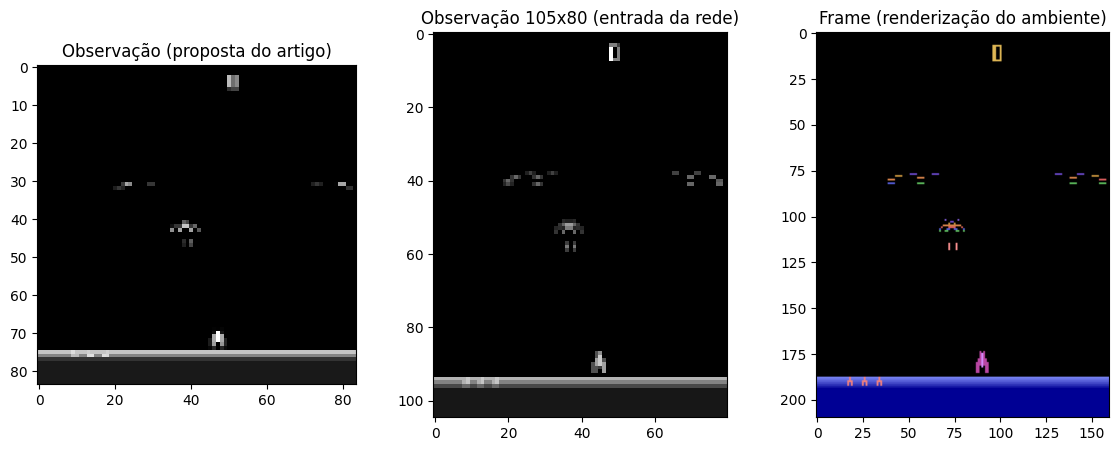

In [2]:
env = gym.make("DemonAttackNoFrameskip-v4", obs_type="grayscale", render_mode="rgb_array")
# Não muda nada, mas evita warnings
env.metadata["render_fps"] = 60
env.reset()
for _ in range(100):
    data = env.step(0)
observation = tf.image.resize(data[0][:, :, None], (84, 84))
other_observation = tf.image.resize(data[0][:, :, None], (105, 80))
frame = env.render()

print("Espaço de observações:", env.observation_space)
print("Espaço de ações:", env.action_space)
n_actions = env.action_space.n
env.close()

fig, ax = plt.subplots(1, 3, figsize=(14, 5))
ax[0].imshow(observation, cmap="gray")
ax[0].title.set_text("Observação (proposta do artigo)")
ax[1].imshow(other_observation, cmap="gray")
ax[1].title.set_text("Observação 105x80 (entrada da rede)")
ax[2].imshow(frame)
ax[2].title.set_text("Frame (renderização do ambiente)")
plt.show()

Ações:

<table class="docutils align-default">
<thead>
<tr class="row-odd"><th class="head"><p>Value</p></th>
<th class="head"><p>Meaning</p></th>
<th class="head"><p>Value</p></th>
<th class="head"><p>Meaning</p></th>
<th class="head"><p>Value</p></th>
<th class="head"><p>Meaning</p></th>
</tr>
</thead>
<tbody>
<tr class="row-even"><td><p><code class="docutils literal notranslate"><span class="pre">0</span></code></p></td>
<td><p><code class="docutils literal notranslate"><span class="pre">NOOP</span></code></p></td>
<td><p><code class="docutils literal notranslate"><span class="pre">1</span></code></p></td>
<td><p><code class="docutils literal notranslate"><span class="pre">FIRE</span></code></p></td>
<td><p><code class="docutils literal notranslate"><span class="pre">2</span></code></p></td>
<td><p><code class="docutils literal notranslate"><span class="pre">RIGHT</span></code></p></td>
</tr>
<tr class="row-odd"><td><p><code class="docutils literal notranslate"><span class="pre">3</span></code></p></td>
<td><p><code class="docutils literal notranslate"><span class="pre">LEFT</span></code></p></td>
<td><p><code class="docutils literal notranslate"><span class="pre">4</span></code></p></td>
<td><p><code class="docutils literal notranslate"><span class="pre">RIGHTFIRE</span></code></p></td>
<td><p><code class="docutils literal notranslate"><span class="pre">5</span></code></p></td>
<td><p><code class="docutils literal notranslate"><span class="pre">LEFTFIRE</span></code></p></td>
</tr>
</tbody>
</table>

In [3]:
mapping = {
    (pygame.K_a, pygame.K_d, pygame.K_SPACE): 1,    # Atirar
    (pygame.K_d, pygame.K_SPACE): 4,                # Direita e atirar
    (pygame.K_a, pygame.K_SPACE): 5,                # Esquerda e atirar
    (pygame.K_a, pygame.K_d): 0,                    # Ficar parado
    pygame.K_SPACE: 1,                              # Atirar
    pygame.K_d: 2,                                  # Direita
    pygame.K_a: 3                                   # Esquerda
}

In [4]:
class PunishHidingCallback(RewardCallback):
    start = 25
    stop = 136
    last = stop - start - 1

    def __init__(
        self, reward_reduction: float = 0.01, history_size: int = 15, tolerance: float = 0.9
    ) -> None:
        """
        Callback de pré-processamento do Demon Attack para punir
        o agente por ficar escondido em um canto da tela.

        Parâmetros
        ----------
        reward_reduction : float, default=0.01
            A variação da recompensa a ser aplicada.
        history_size : int, default=15
            O tamanho do histórico de observações a ser considerado.
        tolerance : float, default=0.9
            A tolerância para considerar que o agente está escondido.
        """
        self.history = np.zeros(history_size, dtype=bool)
        self.reward_reduction = reward_reduction
        self.tolerance = tolerance
        self.index = 0

    def __call__(self, observation: np.ndarray, reward: float) -> float:
        # Verifica a última linha com pixels da nave
        locations = np.where(observation[185, slice(self.start, self.stop)] == 115)[0]
        if len(locations) > 0 and locations[0] in [0, self.last]:
            self.history[self.index] = True
        else:
            self.history[self.index] = False
        self.index = (self.index + 1) % self.history.size
        return reward - self.reward_reduction if np.mean(self.history) >= self.tolerance else reward

In [5]:
class LoseLifeOnHit(TerminationCallback):
    """
    Callback que determina a morte do agente em DemonAttack aproximadamente
    60 frames antes da sinalização pelo ambiente, de modo a não processar
    frames desnecessários e melhorar o entendimento de causalidade.

    Parâmetros
    ----------
    life_loss_reward : float, default=-0.1
        A recompensa a ser aplicada quando o agente perde uma vida, opcionalmente.
    termination_reward : float, default=-1.0
        A recompensa a ser aplicada quando o agente perde a última vida, opcionalmente.
    """
    def __init__(
        self, life_loss_reward: float | None = -0.1, termination_reward: float | None = -1.0
    ) -> None:
        self.life_loss_reward = life_loss_reward
        self.termination_reward = termination_reward

    def __call__(
        self, observation: np.ndarray, reward: float, info: dict[str, Any]
    ) -> tuple[bool, bool, float]:
        life_lost, episode_ended = False, False
        # Fundo deixa de ser escuro quando o jogador é atingido
        if observation[5, 0] > 0:
            life_lost = True
            episode_ended = info["lives"] == 1
            if episode_ended:
                reward = self.termination_reward or reward
            else:
                reward = self.life_loss_reward or reward
        return life_lost, episode_ended, reward

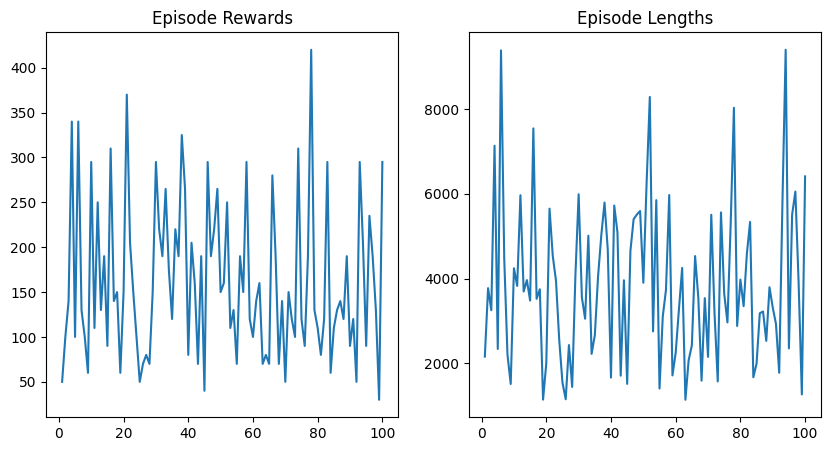

In [6]:
"""
ALE/DemonAttack-v5 pula 4 frames, que é indesejado.
Possíveis argumentos são:
mode: {1, 3, 5, 7}
difficulty: {0, 1, 2, 3}
"""
game = AtariGame(
    "DemonAttackNoFrameskip-v4",
    RandomAgent(n_actions, random_seed=42),
    rotated=True,
    human_agent=HumanAgent(mapping)
)
game.test(max_episodes=100)
game.plot_results()

In [7]:
game.rl_agent = DeepQAgent("baseline", n_actions, (84, 84), n_top_saved=1, max_episodes=20)
game.set_plot_data({
    "Model Loss": (500, game.rl_agent.model.huber_loss)
})
game.rl_agent.model.summary()

Model: "QValueNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 72, 72, 32)        3232      
                                                                 
 conv2d_1 (Conv2D)           (None, 70, 70, 32)        9248      
                                                                 
 flatten (Flatten)           (None, 156800)            0         
                                                                 
 dense (Dense)               (None, 256)               40141056  
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 output (Dense)              (None, 6)                 774       
                                                                 
Total params: 40187206 (153.30 MB)
Trainable params: 4018

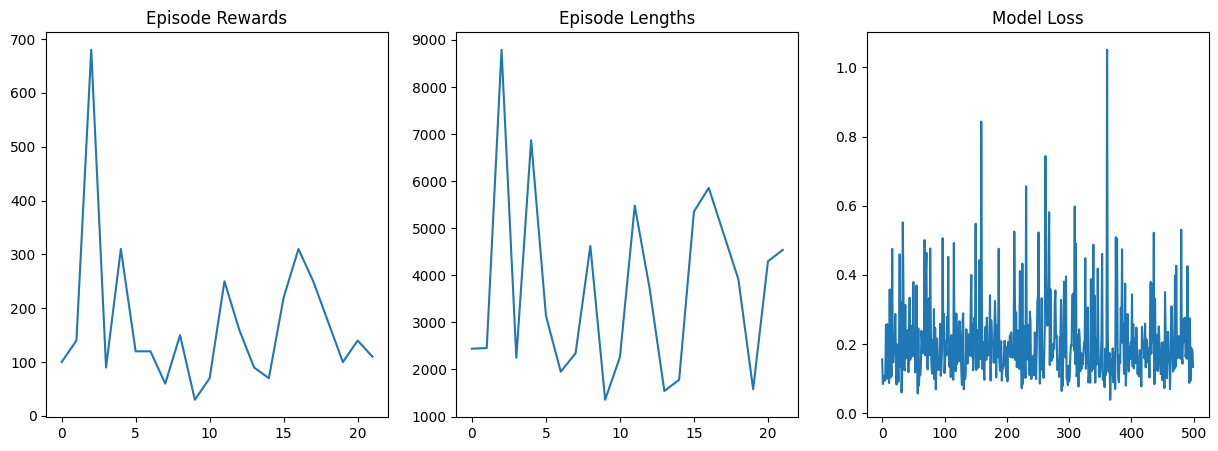

In [8]:
game.train()

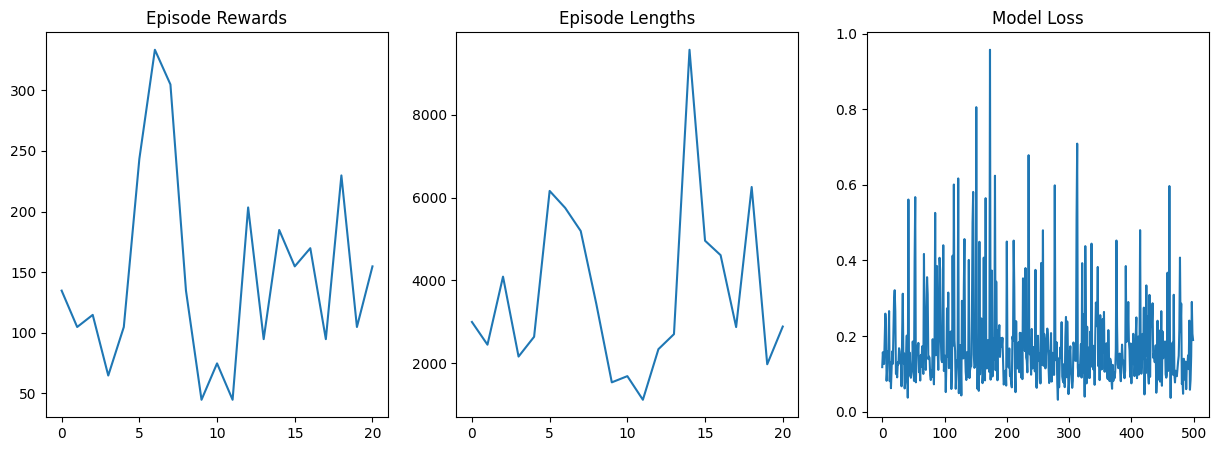

{'lives': 1, 'episode_frame_number': 2887, 'frame_number': 166955}                 


In [ ]:
game.rl_agent = DeepQAgent("death_rewards", n_actions, (84, 84), n_top_saved=1, max_episodes=20)
game.extra_plot_data["Model Loss"] = (500, game.rl_agent.model.huber_loss)
# Recompensa negativa por perda de vida e fim de episódio
game.termination_callback=LoseLifeOnHit()
game.train()

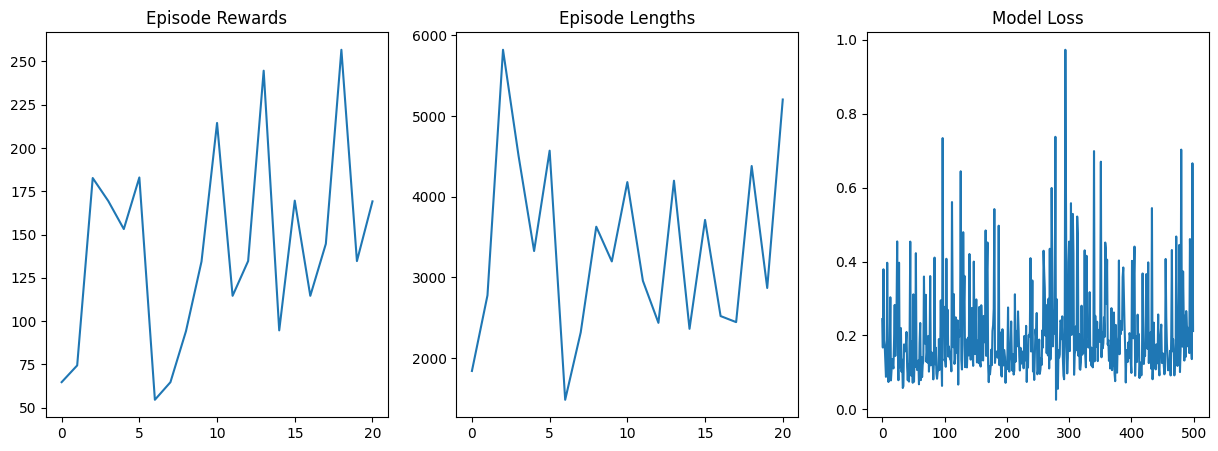

{'lives': 1, 'episode_frame_number': 5205, 'frame_number': 237739}                 


In [ ]:
game.rl_agent = DeepQAgent("pacifist_rewards", n_actions, (84, 84), n_top_saved=1, max_episodes=20)
game.extra_plot_data["Model Loss"] = (500, game.rl_agent.model.huber_loss)
# Diminui a recompensa positiva por demorar para matar inimigos
game.reward_callbacks = [
    PunishPacifistCallback()
]
game.train()

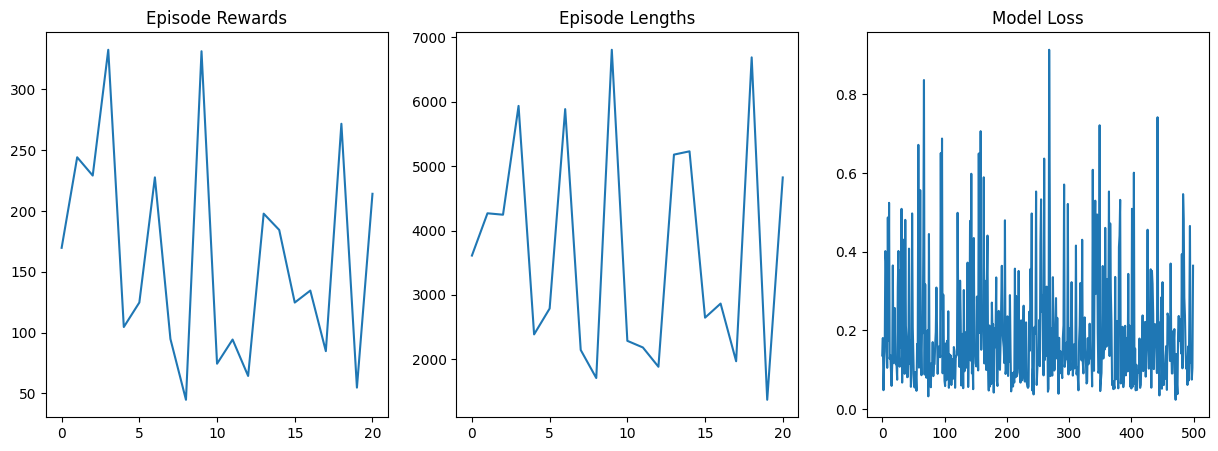

{'lives': 1, 'episode_frame_number': 4825, 'frame_number': 314679}                 


In [ ]:
game.rl_agent = DeepQAgent("hider_rewards", n_actions, (84, 84), n_top_saved=1, max_episodes=20)
game.extra_plot_data["Model Loss"] = (500, game.rl_agent.model.huber_loss)
game.reward_callbacks = [
    PunishHidingCallback()
]
game.train()

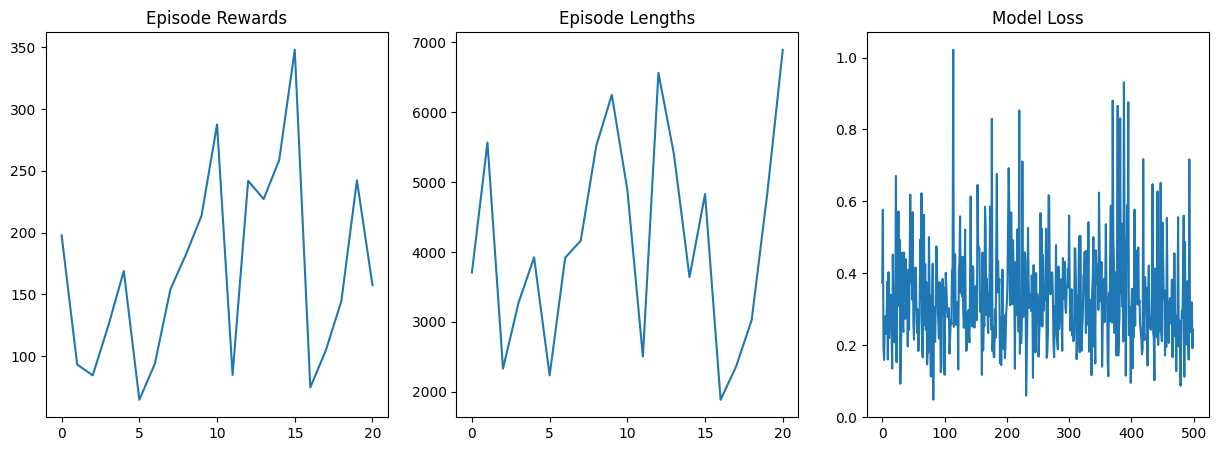

{'lives': 1, 'episode_frame_number': 6892, 'frame_number': 402413}                 


In [ ]:
game.rl_agent = DeepQAgent("all_rewards", n_actions, (84, 84), n_top_saved=1, max_episodes=20)
game.extra_plot_data["Model Loss"] = (500, game.rl_agent.model.huber_loss)
game.reward_callbacks = [
    PunishPacifistCallback(), PunishHidingCallback()
]
game.train()

## Aplicando descobertas

Usamos o início dos treinamentos para definir quais callbacks serão usados para modificar o ambiente, então treinamos um modelo mais leve e com algumas técnicas de regularização para evitar overfitting.

In [14]:
layers = [
    keras.layers.Conv2D(64, 5, activation="relu", dilation_rate=(5, 5)),
    keras.layers.Conv2D(32, 5, activation="relu", dilation_rate=(3, 3)),
    keras.layers.Conv2D(16, 3, activation="relu"),
    keras.layers.Flatten(),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.01),
    keras.layers.Dense(512, activation="relu"),
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dense(128, activation="relu"),
]

game.rl_agent = DeepQAgent(
    "final", n_actions, (105, 80), gamma=0.99, tau=0.1, epsilon_min=0.3,
    max_episodes=100, model_layers=layers
)
game.extra_plot_data["Model Loss"] = (500, game.rl_agent.model.huber_loss)
game.rl_agent.model.summary()

Model: "QValueNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 85, 60, 64)        6464      
                                                                 
 conv2d_20 (Conv2D)          (None, 73, 48, 32)        51232     
                                                                 
 conv2d_21 (Conv2D)          (None, 71, 46, 16)        4624      
                                                                 
 flatten_9 (Flatten)         (None, 52256)             0         
                                                                 
 batch_normalization_1 (Bat  (None, 52256)             209024    
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 52256)             0         
                                                         

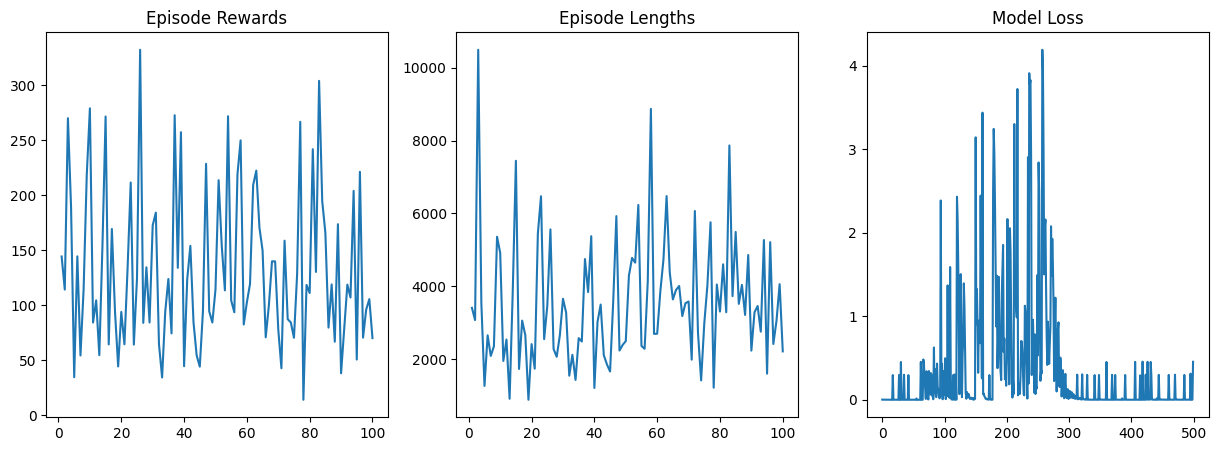

{'lives': 1, 'episode_frame_number': 2213, 'frame_number': 770244}                 


In [25]:
game.train()

In [32]:
game.close()
game.set_plot_data({})

In [36]:
game.rl_agent.load(name="baseline", load_memory=False)

In [ ]:
game.test(render=True)
game.plot_results()

## Conclusão

Apesar das tentativas em diversos aspectos, não conseguimos um modelo que equilibre bem o ataque aos inimigos e a esquiva dos deles. Em treinamentos prolongados, geralmente é possível observar um pico de recompensa, provavelmente ao acaso, pois não é repetido mesmo ao interromper a exploração do ambiente.